In [0]:
!pip install --upgrade pip
!pip install category_encoders
!pip install unidecode
!pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master
!pip install optuna
!pip install --upgrade scikit_learn


In [1]:
import os
%matplotlib inline
import time
import imp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn
import unidecode

In [2]:
from problem import get_train_data

X_df, y_array = get_train_data()

# Preprocessing Pipeline

# Imputing missing values of X_df

In [5]:
# some parameters

ape_code_length = 4

In [6]:
# keeping first 2 numbers of APE
t = time.time()
X_df['Activity_code (APE)'] = X_df['Activity_code (APE)'].fillna(value = '000').astype('str').apply(lambda x: x[:ape_code_length])

# infer zipcode from city

if(True):
    X_df['Zipcode'] = X_df['Zipcode'].astype('str').apply(lambda x: x[:2])
    city_names = X_df[['Zipcode', 'City']].groupby('Zipcode').City.apply(list).values
    zipcodes = X_df[['Zipcode', 'City']].groupby('Zipcode').City.apply(list).index
    zip_dict = {zipcode:list(set(cities)) for zipcode,cities in zip(zipcodes, city_names)}
    
    #remove nans from city lists
    
    for key in zip_dict.keys():
        for i, city in enumerate(zip_dict[key]):
            if type(city) != type('a string'):
                zip_dict[key].pop(i)
           
    # infer zip by checking lists
    
    def infer_zip(city):
        for key in zip_dict:
            if city in zip_dict[key]:
                return key
    
    X_df.loc[X_df['Zipcode'] == 'na', 'Zipcode'] = X_df.loc[X_df['Zipcode'] == 'na', 'City'].apply(infer_zip)
    X_df.loc[X_df['Zipcode'] == 'na', 'Zipcode'] = '00'
    X_df['Zipcode'] = X_df['Zipcode'].fillna('00')
    
# fill name and lower

X_df['Name'] = X_df['Name'].fillna('nan').str.lower().astype('str').apply(unidecode.unidecode)

# Fill headcounts

if(True):
    headcounts = X_df[['Name', 'Headcount']].groupby('Name').mean().fillna(0).to_dict()['Headcount']
    names = X_df['Name'].values
    heads = np.zeros(len(names))

    for i,name in enumerate(names):
        if type(name) == type('a string'):
            heads[i] = headcounts[name]

    X_df['Headcount'] = heads

# unicode and lower

X_df['City'] = X_df['City'].fillna('nan').str.lower().apply(unidecode.unidecode)

# Drop Address

# X_df no longer has NAs

In [8]:
award = pd.read_csv('data/award_notices_RAMP.csv.zip', compression='zip')

city_list = [unidecode.unidecode(i.lower()) for i in list(set(X_df['City'].values))]

def cedex_remover(s):
    s = s.replace('-', ' ').replace(',', ' ')
    tokens = s.split(' ')
    for k in range(len(tokens)):
        for j in range(1, len(tokens)-k + 1):
            if ' '.join(tokens[k:k+j]) in city_list:
                return ' '.join(tokens[k:k+j])
    return None

award.head(3)

print(award.shape)

# unidecode incumbent_name and lower

award['incumbent_name'] = award['incumbent_name'].str.lower().astype('str').apply(unidecode.unidecode)

# preprocess incumbent_city and fill nans
award['incumbent_city'] = award['incumbent_city'].str.lower().astype('str').apply(unidecode.unidecode).apply(cedex_remover).fillna('nan')


# Remove NA in department of provision and keep first 2
award = award[award['Departments_of_publication'].notna()]
award['Departments_of_publication'] = award['Departments_of_publication'].astype('str').apply(lambda x: x.split(',')[0][:2])


C:\Users\adeik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(304098, 28)


In [9]:
# city mean FAN

city_mean_fan = award[['incumbent_city','amount']].groupby('incumbent_city').quantile(0.5).fillna(0).to_dict()['amount']

city_lower_mean = award[['incumbent_city','amount']].groupby('incumbent_city').quantile(0.25).fillna(0).to_dict()['amount']
city_higher_mean = award[['incumbent_city','amount']].groupby('incumbent_city').quantile(0.75).fillna(0).to_dict()['amount']

In [10]:
# zip mean FAN

zip_mean_fan = award[['Departments_of_publication','amount']].groupby('Departments_of_publication').quantile(0.5).fillna(0).to_dict()['amount']

zip_lower_mean = award[['Departments_of_publication','amount']].groupby('Departments_of_publication').quantile(0.25).fillna(0).to_dict()['amount']
zip_higher_mean = award[['Departments_of_publication','amount']].groupby('Departments_of_publication').quantile(0.75).fillna(0).to_dict()['amount']

In [11]:
# APE mean FAN
company_list = [unidecode.unidecode(str(i).lower()) for i in list(set(X_df['Name'].values))]

company_awards = award[award['incumbent_name'].isin(company_list)]

ape_companies = X_df[['Name', 'Activity_code (APE)']].groupby('Name')['Activity_code (APE)'].apply(lambda x: list(x)[0])
ape_companies.index = ape_companies.index.str.lower()
ape_companies = ape_companies.to_dict()

def infer_ape(name):
    return ape_companies[name]
company_awards['APE'] = company_awards['incumbent_name'].apply(infer_ape)

ape_mean_fan = company_awards[['APE','amount']].groupby('APE').quantile(0.5).fillna(0).to_dict()['amount']
ape_lower_mean = company_awards[['APE','amount']].groupby('APE').quantile(0.25).fillna(0).to_dict()['amount']
ape_higher_mean = company_awards[['APE','amount']].groupby('APE').quantile(0.75).fillna(0).to_dict()['amount']

C:\Users\adeik\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [12]:
# Actual FAN revenue

fan_revenue = company_awards[['incumbent_name','amount']].groupby('incumbent_name').sum().fillna(0).to_dict()['amount']


In [13]:
# Insert features into X_df

# Ape FAN
if(True):
    def infer_ape_fan(APE):
        try:
            return np.log10(ape_mean_fan[APE] + 1)
        except:
            return 0

    def infer_low_ape_fan(APE):
        try:
            return np.log10(ape_lower_mean[APE] + 1)
        except:
            return 0

    def infer_high_ape_fan(APE):
        try:
            return np.log10(ape_higher_mean[APE] + 1)
        except:
            return 0



    X_df['APE_fan_0.5'] = X_df['Activity_code (APE)'].apply(infer_ape_fan)
    X_df['APE_fan_0.25'] = X_df['Activity_code (APE)'].apply(infer_low_ape_fan)
    X_df['APE_fan_0.75'] = X_df['Activity_code (APE)'].apply(infer_high_ape_fan)

# City FAN
if(True):

    def infer_city_fan(city):
        try:
            return np.log10(city_mean_fan[city] + 1)
        except:
            return 0

    def infer_low_city_fan(city):
        try:
            return np.log10(city_lower_mean[city] + 1)
        except:
            return 0

    def infer_high_city_fan(city):
        try:
            return np.log10(city_higher_mean[city] + 1)
        except:
            return 0


    X_df['city_fan_0.5'] = X_df['City'].apply(infer_city_fan)
    X_df['city_fan_0.25'] = X_df['City'].apply(infer_low_city_fan)
    X_df['city_fan_0.75'] = X_df['City'].apply(infer_high_city_fan)

# Zip_fan
if(True):
    def infer_zip_fan(zipcode):
        try:
            return np.log10(zip_mean_fan[zipcode] + 1)
        except:
            return 0

    def infer_low_zip_fan(zipcode):
        try:
            return np.log10(zip_lower_mean[zipcode] + 1)
        except:
            return 0

    def infer_high_zip_fan(zipcode):
        try:
            return np.log10(zip_higher_mean[zipcode] + 1)
        except:
            return 0

    X_df['zip_fan_0.5'] = X_df['Zipcode'].apply(infer_zip_fan)
    X_df['zip_fan_0.25'] = X_df['Zipcode'].apply(infer_low_zip_fan)
    X_df['zip_fan_0.75'] = X_df['Zipcode'].apply(infer_high_zip_fan)

# Actual FAN
if(True):
    def infer_fan(name):
        try:
            return np.log10(fan_revenue[name] + 1)
        except:
            return 0

    X_df['FAN'] = X_df['Name'].apply(infer_fan)


In [14]:
time.time() - t

358.44975066185

In [15]:
to_dummy = ['Activity_code (APE)', 'Zipcode', 'Year', 'City', 'Fiscal_year_end_date']
to_drop = ['Name', 'Address']


X_df = X_df.drop(to_drop, axis = 1)
X_df['y'] = y_array

In [16]:
from binascii import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32


def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]



X_train, X_test = split_train_test_by_id(X_df, 0.2, 'Legal_ID')
y_train = np.log10(np.max(np.array([X_train['y'], np.ones(X_train.shape[0])]), axis = 0))
X_train = X_train.drop(['Legal_ID', 'y'], axis = 1)

y_test = np.log10(np.max(np.array([X_test['y'], np.ones(X_test.shape[0])]), axis = 0))
X_test = X_test.drop(['Legal_ID', 'y'], axis = 1)

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import Lasso
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import category_encoders as ce

In [18]:
from scipy import sparse

count_enc = ce.CountEncoder()
scaler = StandardScaler()


cat = X_train[to_dummy]
num = X_train.drop(to_dummy, axis = 1)

num_columns = num.columns
num = scaler.fit_transform(num)
cat = count_enc.fit_transform(cat)

X_train = np.concatenate([num, cat], axis = 1)


cat = X_test[to_dummy]
num = X_test.drop(to_dummy, axis = 1)

num = scaler.transform(num)
cat = count_enc.transform(cat)

X_test = np.concatenate([num, cat.fillna(0)], axis = 1)


#poly = PolynomialFeatures(degree = 2)

#X_train = poly.fit_transform(X_train)

#X_test = X_test.to_numpy()
#X_test = scaler.transform(X_test)
#X_test = poly.transform(X_test)


In [21]:
def nplogloss(ytrue, ypreds, **kwargs):
    score1 = np.max([5 * np.ones(len(ytrue)), ypreds], axis = 0)
    score2 = np.max([5 * np.ones(len(ytrue)), ytrue], axis = 0)
    score = np.abs(score1 - score2)
    return np.mean(score)

In [ ]:
t = time.time()
import optuna
from sklearn.model_selection import cross_val_score

param_grid = {'max_depth': 189, 'max_iter': 262, 'max_leaf_nodes': 277, 'min_samples_leaf': 1133}

count = 0
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 150, 500)
    learning_rate = trial.suggest_loguniform('learning_rate', 10**-3, 10**0)
    max_iter = trial.suggest_int('max_iter', 200, 500)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 200, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 600, 1200)

    reg = HistGradientBoostingRegressor(
        max_depth=max_depth,
        max_iter = max_iter,
        learning_rate = learning_rate,
        max_leaf_nodes=max_leaf_nodes,
        min_samples_leaf=min_samples_leaf)
    
    reg.fit(X_train, y_train)
    global count
    count += 1
    print(count)
    
    y_pred = reg.predict(X_test)
    return nplogloss(y_test, y_pred)

study = optuna.create_study(direction='minimize')
optuna.logging.disable_default_handler()  # limit verbosity
study.optimize(objective, n_trials=100)

# Show best result
print(time.time() - t)
print(study.best_trial.params)
print(study.best_trial.value)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


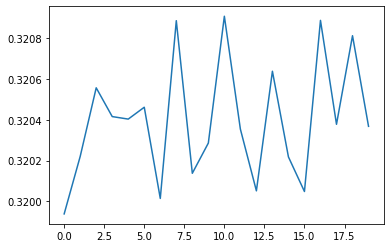

In [136]:
values = [t.value for t in study.trials]
plt.plot(values)